# 🏗️ Synthetic Data Generation

The first dataset generated uses 3D models of drones (object) placed into a real background image (canvas).

Number of images:
- `Training = 20264 / 4 = 5066`
- `Validation = 4304 / 4 = 1076`

Test data will reuse the original data set for comparison.

In [12]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from src import utils

## 1. Canvas Images

Select a set of canvas images to use for training and validation sets.

In [3]:
# Get the list of images
canvas_imgs = utils.files.get_image_files(os.path.join(utils.EXTERNAL_DATA_DIR, "canvas"))
print(f"There are {len(canvas_imgs)} images.")

There are 77 images.


In [4]:
# Split the images into 80%/20% training/validation
trn_amount = int(0.8 * 77)

trn_canvases = np.random.choice(canvas_imgs, size=trn_amount, replace=False)

val_canvases = [canvas for canvas in canvas_imgs if canvas not in trn_canvases]

print(f"{len(trn_canvases)} training image canvases and {len(val_canvases)} validation image canvases.")

61 training image canvases and 16 validation image canvases.


In [5]:
# Save the lists for later use
trn_canvases = pd.Series(trn_canvases)
val_canvases = pd.Series(val_canvases)

trn_canvases.to_csv(os.path.join(utils.EXTERNAL_DATA_DIR, "canvas", "trn_cache.csv"), index=False)
val_canvases.to_csv(os.path.join(utils.EXTERNAL_DATA_DIR, "canvas", "val_cache.csv"), index=False)

In [2]:
# Read the lists back in
trn_canvases = pd.read_csv(os.path.join(utils.EXTERNAL_DATA_DIR, "canvas", "trn_cache.csv"))
val_canvases = pd.read_csv(os.path.join(utils.EXTERNAL_DATA_DIR, "canvas", "val_cache.csv"))

print(f"{len(trn_canvases)} training image canvases and {len(val_canvases)} validation image canvases.")

61 training image canvases and 16 validation image canvases.


## 2. Objects

Select the objects to use for the images.

In [3]:
# Get the list of 3D model files
model_paths = utils.files.get_3d_model_files(os.path.join(utils.EXTERNAL_DATA_DIR, "3d_models"))

In [4]:
# Load each of the model files into memory as a vtk object
models_list = []
for path in model_paths:
    name = os.path.splitext(os.path.basename(path))[0]
    model = utils.synth.load_3d_model(path)
    models_list.append((name, model))

Objects will be further manipulated at a later stage as they are placed onto the canvas.

## 3. Data Generation

Generate data for the training and validation sets.

### a. Training Data

Create a synthetic data set for training images. The number of images is before the multi-scale splitting that was performed where the images were split into 4 pieces. After generation the images will be cut in the same way to make them similar to the original baseline data.

In [15]:
# Set the number of training data images to create
training_total = 5066  # Actual = 5066

In [16]:
# Set the data directory
train_data_dir = os.path.join(utils.INTERIM_DATA_DIR, "3d_model_data", "train")

# Create the folders if they don't exist
os.makedirs(train_data_dir, exist_ok=True)

In [17]:
# Set a random number generator seed for reproducibility
rng = np.random.default_rng(seed=42)

# Loop to create training data equal to the total number specified
for i in range(training_total):
    
    # Create a base file name for the final image and annotation file
    base_filename = f"3d_model_img_{i:05d}"
    
    if i % 100 == 0:
        print(f"Creating training image {i} of {training_total}")

    # Randomly select a canvas image
    canvas_path = rng.choice(trn_canvases)[0]
    canvas = Image.open(canvas_path)
    canvas_size = canvas.size

    # Select a random number of models to place in the canvas
    num_models = rng.integers(low=1, high=6)

    # Loop for each model to be placed
    for m in range(num_models):
        # Randomly select a 3D model file
        name, model = rng.choice(models_list)
        
        # Handle models with specific initial orientations
        if "shahed" in name:
            # Set initial orientation
            init_pitch = -90
            init_yaw = 0
            init_roll = -90
            
        elif "dji_m600" in name:
            # Set initial orientation
            init_pitch = 0
            init_yaw = 0
            init_roll = 0
            
        else:
            # Set initial (default) orientation
            init_pitch = 0
            init_yaw = -90
            init_roll = 0
            
        # Set a seed for the model randomization
        model_seed = (i + 1) * 10 + (m + 1)
        
        # Orient the model randomly
        model = utils.synth.camera_view(model, init_pitch=init_pitch, init_yaw=init_yaw, init_roll=init_roll, randomize=True, seed=model_seed)
        model_img = utils.synth.vtk_to_PIL(model)
        
        # Scale the object to a random size
        # Scale is a factor of the canvas size
        scale_factor = utils.synth.rng_scale(seed=model_seed)
        model_img = utils.synth.scale_obj(model_img, scale_factor, canvas_size)
        # Width and height ratios for annotation
        obj_width = model_img.size[0] / canvas_size[0]
        obj_height = model_img.size[1] / canvas_size[1]
        
        # Randomly position the object within the canvas
        coordinates_topleft = utils.synth.rng_position(model_img.size, canvas_size, seed=model_seed)
        # Calculate the center coordinates for annotation
        x_center = (coordinates_topleft[0] + model_img.size[0] / 2) / canvas_size[0]
        y_center = (coordinates_topleft[1] + model_img.size[1] / 2) / canvas_size[1]
        
        # Paste the object onto the canvas
        canvas.paste(model_img, coordinates_topleft, model_img)
        
        # Add the annotation for the object to the annotation text file
        ann = [0, x_center, y_center, obj_width, obj_height]  # Class is 0 since all objects are the same class
        with open(os.path.join(train_data_dir, f"{base_filename}.txt"), "a") as ann_file:
            ann_file.write(" ".join([str(a) for a in ann]) + "\n")
            
    # Save the final image
    canvas.save(os.path.join(train_data_dir, f"{base_filename}.png"))

Creating training image 0 of 5066
Creating training image 100 of 5066
Creating training image 200 of 5066
Creating training image 300 of 5066
Creating training image 400 of 5066
Creating training image 500 of 5066
Creating training image 600 of 5066
Creating training image 700 of 5066
Creating training image 800 of 5066
Creating training image 900 of 5066
Creating training image 1000 of 5066
Creating training image 1100 of 5066
Creating training image 1200 of 5066
Creating training image 1300 of 5066
Creating training image 1400 of 5066
Creating training image 1500 of 5066
Creating training image 1600 of 5066
Creating training image 1700 of 5066
Creating training image 1800 of 5066
Creating training image 1900 of 5066
Creating training image 2000 of 5066
Creating training image 2100 of 5066
Creating training image 2200 of 5066
Creating training image 2300 of 5066
Creating training image 2400 of 5066
Creating training image 2500 of 5066
Creating training image 2600 of 5066
Creating trai

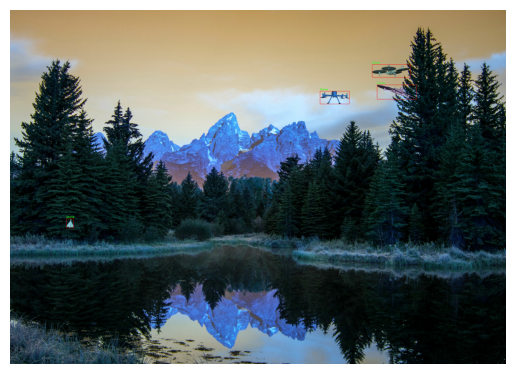

In [18]:
# Check bounding boxes
trn_imgs = utils.files.get_image_files(train_data_dir)
ann_files = utils.files.get_annotation_files(train_data_dir)

random_img = rng.integers(low=0, high=len(trn_imgs))
trn_img = trn_imgs[random_img]
ann_file = ann_files[random_img]

bboxes = utils.label_data.read_bbox_file(ann_file)

xxyy_bboxes = []
for bbox in bboxes:
    xxyy_bbox = utils.label_data.bbox_xxyy(bbox)
    xxyy_bboxes.append(xxyy_bbox)

bbox_img = utils.image_data.draw_bbox(trn_img, xxyy_bboxes)

plt.imshow(bbox_img)
plt.axis('off')
plt.show()

### b. Validation Data

In [ ]:
# Set the number of validation data images to create
validation_total = 1076  # Actual = 1076

In [ ]:
# Set the data directory
val_data_dir = os.path.join(utils.INTERIM_DATA_DIR, "3d_model_data", "val")

# Create the folders if they don't exist
os.makedirs(val_data_dir, exist_ok=True)

In [ ]:
# Set a random number generator seed for reproducibility
rng = np.random.default_rng(seed=12345)

# Loop to create training data equal to the total number specified
for i in range(validation_total):
    
    # Create a base file name for the final image and annotation file
    base_filename = f"3d_model_img_v_{i:05d}"
    
    if i % 100 == 0:
        print(f"Creating validation image {i} of {validation_total}")

    # Randomly select a canvas image
    canvas_path = rng.choice(val_canvases)[0]
    canvas = Image.open(canvas_path)
    canvas_size = canvas.size

    # Select a random number of models to place in the canvas
    num_models = rng.integers(low=1, high=6)

    # Loop for each model to be placed
    for m in range(num_models):
        # Randomly select a 3D model file
        name, model = rng.choice(models_list)
        
        # Handle models with specific initial orientations
        if "shahed" in name:
            # Set initial orientation
            init_pitch = -90
            init_yaw = 0
            init_roll = -90
            
        elif "dji_m600" in name:
            # Set initial orientation
            init_pitch = 0
            init_yaw = 0
            init_roll = 0
            
        else:
            # Set initial (default) orientation
            init_pitch = 0
            init_yaw = -90
            init_roll = 0
            
        # Set a seed for the model randomization
        model_seed = (i + 1) * 100 + (m + 1)
        
        # Orient the model randomly
        model = utils.synth.camera_view(model, init_pitch=init_pitch, init_yaw=init_yaw, init_roll=init_roll, randomize=True, seed=model_seed)
        model_img = utils.synth.vtk_to_PIL(model)
        
        # Scale the object to a random size
        # Scale is a factor of the canvas size
        scale_factor = utils.synth.rng_scale(seed=model_seed)
        model_img = utils.synth.scale_obj(model_img, scale_factor, canvas_size)
        # Width and height ratios for annotation
        obj_width = model_img.size[0] / canvas_size[0]
        obj_height = model_img.size[1] / canvas_size[1]
        
        # Randomly position the object within the canvas
        coordinates_topleft = utils.synth.rng_position(model_img.size, canvas_size, seed=model_seed)
        # Calculate the center coordinates for annotation
        x_center = (coordinates_topleft[0] + model_img.size[0] / 2) / canvas_size[0]
        y_center = (coordinates_topleft[1] + model_img.size[1] / 2) / canvas_size[1]
        
        # Paste the object onto the canvas
        canvas.paste(model_img, coordinates_topleft, model_img)
        
        # Add the annotation for the object to the annotation text file
        ann = [0, x_center, y_center, obj_width, obj_height]  # Class is 0 since all objects are the same class
        with open(os.path.join(val_data_dir, f"{base_filename}.txt"), "a") as ann_file:
            ann_file.write(" ".join([str(a) for a in ann]) + "\n")
            
    # Save the final image
    canvas.save(os.path.join(val_data_dir, f"{base_filename}.png"))

In [ ]:
# Check bounding boxes
val_imgs = utils.files.get_image_files(val_data_dir)
ann_val_files = utils.files.get_annotation_files(val_data_dir)

random_img = rng.integers(low=0, high=len(val_imgs))
val_img = val_imgs[random_img]
ann_val_file = ann_val_files[random_img]

bboxes = utils.label_data.read_bbox_file(ann_val_file)

xxyy_bboxes = []
for bbox in bboxes:
    xxyy_bbox = utils.label_data.bbox_xxyy(bbox)
    xxyy_bboxes.append(xxyy_bbox)

bbox_img = utils.image_data.draw_bbox(trn_img, xxyy_bboxes)

plt.imshow(bbox_img)
plt.axis('off')
plt.show()